<a href="https://colab.research.google.com/github/Xinxinatg/bmsnn/blob/master/Implementing_bmsnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Xinxinatg/bmsnn.git


Cloning into 'bmsnn'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 79 (delta 32), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q /content/drive/'My Drive'/VisDrone2020-CC-DM-counting.zip

#or download from https://drive.google.com/file/d/1FZ6hmOhwoXftKVgRWep_AxKcKS4v1WMQ/view?usp=sharing

Mounted at /content/drive


In [3]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
import sys
sys.path.extend(['/content/bmsnn'])
from utils import get_density_map_gaussian
import matplotlib.pyplot as plt
%matplotlib inline


with_direction = False

In [4]:
root = '/content/VisDrone2020-CC/'

In [5]:
#now generate the ShanghaiA's ground truth
#                part_A_train = os.path.join(root,'part_A_final/train_data','images')
 #               part_A_test = os.path.join(root,'part_A_final/test_data','images')
  #              part_B_train = os.path.join(root,'part_B_final/train_data','images')
   #             part_B_test = os.path.join(root,'part_B_final/test_data','images')
    #            path_sets = [part_A_train,part_A_test]
train = os.path.join(root,'train_data','images')
test = os.path.join(root,'test_data','images')
path_sets = [train,test]

In [ ]:
#root = 'data/ShanghaiTech/'

In [ ]:
#part_A_train = os.path.join(root, 'part_A/train_data', 'images')
#part_A_test = os.path.join(root, 'part_A/test_data', 'images')
#part_B_train = os.path.join(root, 'part_B/train_data', 'images')
#part_B_test = os.path.join(root, 'part_B/test_data', 'images')
#path_sets_A = [part_A_train, part_A_test]
#path_sets_B = [part_B_train, part_B_test]

In [6]:
#img_paths_A = []
#for path in path_sets_A:
 #   for img_path in glob.glob(os.path.join(path, '*.jpg')):
  #      img_paths_A.append(img_path)
#print(len(img_paths_A))
#img_paths_B = []
#for path in path_sets_B:
 #   for img_path in glob.glob(os.path.join(path, '*.jpg')):
 #       img_paths_B.append(img_path)
#print(len(img_paths_B))
img_paths= []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))

2460


In [ ]:
#os.mkdir(base_dir)

In [8]:
#for part in ['A', 'B']:
#for t in ['train', 'test']: 
        #if not os.path.exists('data/ShanghaiTech/part_{}/{}_data/ground/'.format(part, t)):   /content/VisDrone2020-CC/
             #os.mkdir('data/ShanghaiTech/part_{}/{}_data/ground/'.format(part, t))
    #  if not os.path.exists('/content/VisDrone2020-CC/{}_data/ground/'.format(t)):   
     #     os.mkdir('/content/VisDrone2020-CC/{}_data/ground/'.format(t))
templates = []
for i in sorted(glob.glob(os.path.join('data', '*.npy')), key=lambda x: int(x.split('/')[-1].split('.')[0])):
    templates.append(np.load(i))
#for dataset in ['B', 'A']:
#    img_paths = eval('img_paths_'+dataset)
#    if dataset == 'A':
#        is_adaptive = True
#    else:
#        is_adaptive = False
is_adaptive = True
for img_path in tqdm(img_paths):

    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))

    gt = pts["image_info"][0, 0][0, 0][0] - 1

    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = get_density_map_gaussian(
        k, gt, adaptive_mode=is_adaptive
    )

    file_path = img_path.replace('.jpg', '.h5').replace('images', 'ground-truth')

    with h5py.File(file_path, 'w') as hf:
        hf['density'] = k

100%|██████████| 2460/2460 [04:58<00:00,  8.25it/s]


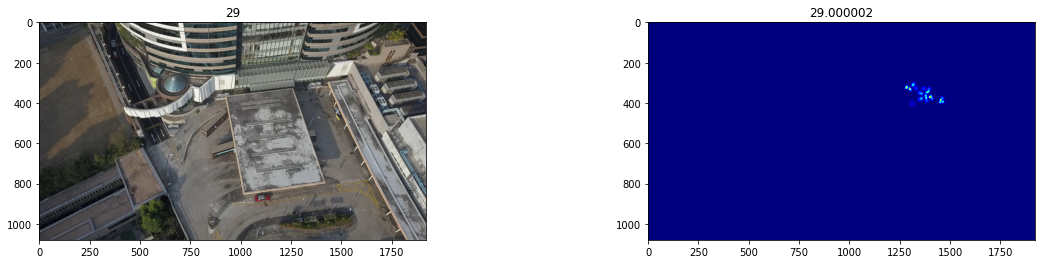

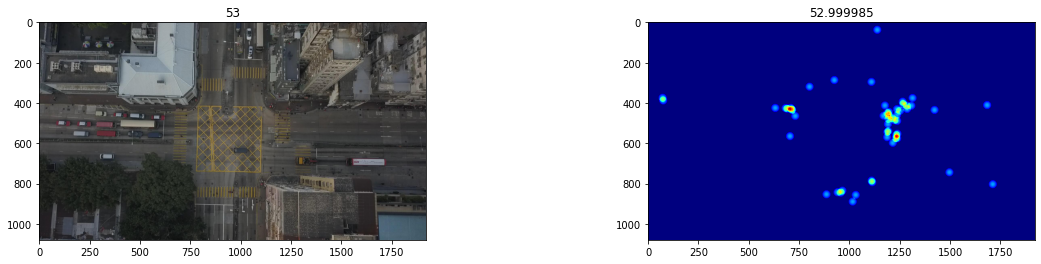

In [10]:
# Show a sample
img_paths = ['/content/VisDrone2020-CC/test_data/images/IMG_00050_00030.jpg',
             '/content/VisDrone2020-CC/test_data/images/IMG_00052_00011.jpg']
from utils import load_img
is_adaptive = False
for img_path in img_paths:
    is_adaptive = not is_adaptive
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))

    gt = pts["image_info"][0, 0][0, 0][0]

    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = get_density_map_gaussian(k, gt, adaptive_mode=is_adaptive)

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(k), cmap=plt.cm.jet)
    ax1.set_title(str(np.sum(k)))
    plt.show()

In [ ]:
import json
from os.path import join
import glob


img1_folder = '/content/VisDrone2020-CC/train_data/images' 
img2_folder = '/content/VisDrone2020-CC/test_data/images' 

# path to the final json file
output1_json = '/content/train.json' 
output2_json = '/content/test.json' 

img1_list = []
img2_list = []

for img_path1 in glob.glob(join(img1_folder,'*.jpg')):
    img1_list.append(img_path1)
  
for img_path2 in glob.glob(join(img2_folder,'*.jpg')):
    img2_list.append(img_path2)

with open(output1_json,'w') as f:
    json.dump(img1_list,f)

with open(output2_json,'w') as h:
    json.dump(img2_list,h)

In [15]:

import json
from os.path import join
import glob
import random


if __name__ == '__main__':
    # path to folder that contains images
    img_folder = '/content/VisDrone2020-CC/train_data/images'  
    img2_folder = '/content/VisDrone2020-CC/test_data/images' 
    # path to the final json file
    train_json = '/content/VisDrone2020-CC/train.json'
    val_json = '/content/VisDrone2020-CC/val.json'
    test_json = '/content/VisDrone2020-CC/test.json'

    train_list = []
    val_list = []
    test_list = []

    for img_path in glob.glob(join(img_folder,'*.jpg')):
        train_list.append(img_path)
    
    for img_path2 in glob.glob(join(img2_folder,'*.jpg')):
        test_list.append(img_path2)


    print("length of train list is",len(train_list))
    print("random train list",train_list[0])
    
    val_num=int((len(train_list)-len(train_list)%7)/7)  
    val_list=random.sample(train_list, val_num)
    train_list = list(set(train_list) - set(val_list))
    with open(train_json,'w') as f_t:
        json.dump(train_list,f_t)
    with open(val_json,'w') as f_v:
        json.dump(val_list,f_v)
    with open(test_json,'w') as h:
        json.dump(test_list,h)

length of train list is 1980
random train list /content/VisDrone2020-CC/train_data/images/IMG_00031_00010.jpg


In [ ]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
import sys
sys.path.extend(['/content/bmsnn'])
from utils import get_density_map_gaussian
import matplotlib.pyplot as plt
%matplotlib inline

with_direction = False
import os
import sys
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
import shutil
from utils import load_img, gen_x_y, eval_loss, gen_paths, ssim_eucli_loss, random_cropping, local_sum_loss, fix_singular_shape

dataset = "B"
with_validation = True
rand_crop = True
%matplotlib inline

#                      img_paths_test, img_paths_train = gen_paths(
 #                         path_file_root='/content/bmsnn/data/paths_train_val_test', 
  #                        dataset=dataset,
   #                       with_validation=with_validation
    #                  )
import json
from os.path import join
import glob

os.rename('/content/VisDrone2020-CC/test_data/ground-truth', '/content/VisDrone2020-CC/test_data/ground') 
os.rename('/content/VisDrone2020-CC/train_data/ground-truth', '/content/VisDrone2020-CC/train_data/ground') 

img_train_folder = '/content/VisDrone2020-CC/train_data/images' 
img_test_folder = '/content/VisDrone2020-CC/test_data/images' 

# path to the final json file
#output_json = '/content/bmsnn/data/paths_train_val_test/paths_B/train.json' 
#                          img_paths_train = []
 #                         img_paths_test = []
#
 #                         for img_path1 in glob.glob(join(img_train_folder,'*.jpg')):
  #                            img_paths_train.append(img_path1)
#
 #                         for img_path2 in glob.glob(join(img_test_folder,'*.jpg')):
  #                            img_paths_test.append(img_path2)

import json

with open('/content/VisDrone2020-CC/val.json') as f:
  img_paths_val = json.load(f)


with open('/content/VisDrone2020-CC/train.json') as f1:
  img_paths_train = json.load(f1)

with open('/content/VisDrone2020-CC/test.json') as f2:
  img_paths_test = json.load(f2)
#img_paths_test=dict(img_paths_test)
#img_paths_train=dict(img_paths_train)
img_paths_test = sorted(img_paths_test, key=lambda x: int(x.split('_')[-1].split('.')[0]))

print (img_paths_test[:])
if with_validation:
    #img_paths_train = list(set(img_paths_train) - set(img_paths_val))
    x_val, y_val, img_paths_val = gen_x_y(img_paths_val, 'val')
    print(len(x_val), len(y_val), len(img_paths_val))
    x_test, y_test, img_paths_test = gen_x_y(img_paths_test, 'test')
    print('Test data size:', len(x_test), len(y_test), len(img_paths_test))
else:
    x_val, y_val, img_paths_val = gen_x_y(img_paths_test[:], 'test')
    print('Validation data size:', len(x_val), len(y_val), len(img_paths_val))
x_train, y_train, img_paths_train = gen_x_y(img_paths_train[:], 'train', augmentation_methods=['ori', 'flip'])
print('Train data size:', len(x_train), len(y_train), len(img_paths_train))
weights_dir = 'weights_' + dataset
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)

['/content/VisDrone2020-CC/test_data/images/IMG_00053_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00055_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00050_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00057_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00051_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00059_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00066_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00052_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00068_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00054_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00067_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00064_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00056_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00060_00001.jpg', '/content/VisDrone2020-CC/test_data/images/IMG_00071_00001.jpg', '/content/VisDrone2020-C

In [ ]:

import os
import shutil
from keras.optimizers import Adam
from utils import ssim_eucli_loss
from bmsnn import BMSNN

dataset = 'B'
weights_dir = 'weights_' + dataset
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)
os.makedirs(weights_dir)
net = 'BMSNN'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
LOSS = 'ssim_eucli_loss'
lr = 1e-4
input_shape = (None, None, 3)

model = BMSNN(input_shape=input_shape, IN=False)
model.summary()
optimizer = Adam(lr=lr)
model.compile(optimizer=optimizer, loss=ssim_eucli_loss)
from keras.utils import plot_model
plot_model(model, 'models/{}.png'.format(net))

In [ ]:
lossMAE = 1e5
lossMDMD, lossMAPE, lossMSE = -1, -1, -1
counter_train = 0
mae = 1e5
mdmd = 1e5
val_rate = 0.25
lossesMDMD = []
lossesMAE = []
lossesMAPE = []
lossesMSE = []
path_val_display = img_paths_val[0]
x_val_display = load_img(path_val_display)
y_val_display = np.squeeze(y_val[0])
x_val_display, y_val_display = fix_singular_shape(x_val_display), fix_singular_shape(y_val_display)
with open('./models/{}.json'.format(net), 'w') as fout:
    fout.write(model.to_json())
if dataset == 'A':
    save_frequencies = [(90, 0.1), (80, 0.05), (95, 0.25)]
else:
    save_frequencies = [(20, 0.1), (15, 0.05), (22, 0.25)]

branches_trainable = [
    list(range(1, 7+1)),
    list(range(8, 14+1)),
    list(range(15, 21+1)),
    list(range(22, 28+1)),
    list(range(29, 34+1))
]
if_train_seperatly = True
if if_train_seperatly:
    module_step = 40
    epoch_train_seperatly = module_step * len(branches_trainable) * 1
    epoch_train = epoch_train_seperatly + 100
else:
    epoch_train = 200

time_st = time.time()
for epoch in range(epoch_train):
    if if_train_seperatly:
        trainable_choice = int(epoch/module_step)
        print('trainable_choice:', trainable_choice)

        if epoch < epoch_train_seperatly and trainable_choice in list(range(len(branches_trainable))):
            branch_trainable = branches_trainable[trainable_choice]
            for i in range(1, len(model.layers)):
                if 'conv' in model.layers[i].name:
                    model.layers[i].trainable = False
            for i in range(1, len(model.layers)):
                idx_operator = int(model.layers[i].name.split('_')[-1])
                if 'conv' in model.layers[i].name and idx_operator in branch_trainable:
                    model.layers[i].trainable = True
            model.compile(optimizer=Adam(lr=lr), loss=ssim_eucli_loss)
        elif epoch == epoch_train_seperatly:
            for i in range(1, len(model.layers)):
                model.layers[i].trainable = True
            model.compile(optimizer=Adam(lr=lr/1), loss=ssim_eucli_loss)
        else:
            pass

    for i in range(len(x_train)):
        if lossMAE < save_frequencies[0][0]:
            val_rate = save_frequencies[0][1]
            if lossMAE < save_frequencies[1][0]:
                val_rate = save_frequencies[1][1]
        if len(lossesMAE) > 100 and val_rate <= save_frequencies[-1][-1] and np.median(lossesMAE[-20]) > save_frequencies[-1][0]:
            val_rate = save_frequencies[-1][-1]
        x_, y_ = x_train[i], y_train[i]
        model.fit(x_, y_, verbose=0)
        counter_train += 1

        if counter_train % int(len(x_train)*val_rate) == 0:
            lossMDMD, lossMAE, lossMAPE, lossMSE = eval_loss(model, x_val, y_val)
            lossesMDMD.append(lossMDMD)
            lossesMAE.append(lossMAE)
            lossesMAPE.append(lossMAPE)
            lossesMSE.append(lossMSE)
            lossMAE, lossMAPE, lossMDMD, lossMSE = round(lossMAE, 3), round(lossMAPE, 3), round(lossMDMD, 3), round(lossMSE, 3)
            if ((lossMAE < mae or lossMDMD < mdmd) and epoch >= 0) or lossMAE < save_frequencies[1][0] * 0.9:
                model.save_weights(
                    os.path.join(weights_dir, '{}_MAE{}_MSE{}_MAPE{}_MDMD{}_epoch{}-{}.hdf5'.format(
                        net, str(lossMAE), str(lossMSE), str(lossMAPE), str(lossMDMD), epoch, (counter_train-1)%len(x_train)
                    ))
                )
                if lossMAE < mae:
                    mae = lossMAE
                    model.save_weights(os.path.join(weights_dir, '{}_best.hdf5'.format(net)))
                if lossMDMD < mdmd:
                    mdmd = lossMDMD
            if counter_train % (len(x_train)*1) == 0:
                pred = np.squeeze(model.predict(np.expand_dims(x_val_display, axis=0)))
                fg, (ax_x_ori, ax_y, ax_pred) = plt.subplots(1, 3, figsize=(20, 4))
                ax_x_ori.imshow(cv2.cvtColor(cv2.imread(path_val_display), cv2.COLOR_BGR2RGB))
                ax_x_ori.set_title('Original Image')
                ax_y.imshow(y_val_display, cmap=plt.cm.jet)
                ax_y.set_title('Ground_truth: ' + str(np.sum(y_val_display)))
                ax_pred.imshow(pred, cmap=plt.cm.jet)
                ax_pred.set_title('Prediction: ' + str(np.sum(pred)))
                plt.suptitle('Loss = ' + str(lossMAE))
                plt.show()
                if counter_train % (len(x_train)*4) == 0 or (epoch+1) % (20) == 0:
                    plt.plot(lossesMAPE, 'y')
                    plt.plot(lossesMAE, 'b')
                    plt.plot(lossesMSE, 'c')
                    plt.plot(lossesMDMD, 'r')
                    plt.legend(['LossMAPE', 'LossMAE', 'LossMSE', 'Loss_Density_Map_Distance'])
                    plt.title('Loss')
                    plt.show()
        time_now = time.time()
        time_consuming = time_now - time_st
        sys.stdout.write('In epoch {}_{}, with MAE={}, MSE={}, MAPE={}, MDMD={}, time consuming={}m-{}s\r'.format(
            epoch, counter_train%len(x_train), str(lossMAE), str(lossMSE), str(lossMAPE), str(lossMDMD),
            int(time_consuming/60), int(time_consuming-int(time_consuming/60)*60)
        ))
        sys.stdout.flush()
end_time_of_train = '-'.join(time.ctime().split()[:-2])
suffix_new_dir = '_{}_{}_bestMAE{}_{}'.format(dataset, LOSS, str(round(mae, 3)), end_time_of_train)
shutil.move('weights_{}'.format(dataset), 'weights'+suffix_new_dir)

loss_dir = 'losses_' + dataset
if not os.path.exists(loss_dir):
    os.makedirs(loss_dir)
np.savetxt(os.path.join(loss_dir, 'loss_DMD.txt'), lossesMDMD)
np.savetxt(os.path.join(loss_dir, 'loss_MAE.txt'), lossesMAE)
np.savetxt(os.path.join(loss_dir, 'loss_MAPE.txt'), lossesMAPE)
np.savetxt(os.path.join(loss_dir, 'loss_MSE.txt'), lossesMSE)
plt.plot(lossesMAPE, 'y')
plt.plot(lossesMAE, 'b')
plt.plot(lossesMSE, 'c')
plt.plot(lossesMDMD, 'r')
plt.legend(['LossMAPE', 'LossMAE', 'LossMSE', 'Loss_Density_Map_Distance'])
plt.title('Loss -- {} epochs'.format(epoch_train))
plt.savefig('./losses_{}/loss_{}_{}.jpg'.format(dataset, dataset, end_time_of_train))
plt.show()
shutil.move('losses_{}'.format(dataset), 'losses'+suffix_new_dir)